In [582]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

import pandas as pd
import numpy as np
import decimal
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from util.db_util import DatabaseUtility
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit


In [583]:
# Read .bashrc and update os.environ
bashrc_path = os.path.expanduser("~/.bashrc")

if os.path.exists(bashrc_path):
    with open(bashrc_path, "r") as f:
        for line in f:
            if line.startswith("export "):
                key_value = line.replace("export ", "").strip().split("=", 1)
                if len(key_value) == 2:
                    key, value = key_value
                    # Strip unnecessary quotes around the value
                    os.environ[key] = value.strip().strip("'").strip('"')

# Initialize database connection
db_util = DatabaseUtility()

# Execute query
db_util.cursor.execute("""
    SELECT * FROM rb_model_data;
""")

# Fetch all rows
rows = db_util.cursor.fetchall()

# Get column names from cursor description
columns = [desc[0] for desc in db_util.cursor.description]

# Create a DataFrame
df = pd.DataFrame(rows, columns=columns)

# Close the database connection
db_util.conn.close()

# Display the first few rows of the DataFrame
print(df.head())

   player_id              name position  draft_cap  production_score  \
0       4827   Jorvorskie Lane       RB        NaN           31.6647   
1       6973   Latavius Murray       RB      181.0           28.6068   
2       7035      Tauren Poole       RB        NaN           32.0297   
3       7164        Jonas Gray       RB        NaN           24.4976   
4       7683  Kerwynn Williams       RB      230.0           38.1246   

   size_score  cupps_score   ras  height  weight  ...  peak_yac_per_att  \
0      62.500      22.2909   NaN     NaN     NaN  ...               NaN   
1      98.725      27.8234  9.83    75.0   230.0  ...               NaN   
2      62.500      22.4278   NaN     NaN     NaN  ...               NaN   
3      62.500      19.6033   NaN     NaN     NaN  ...               NaN   
4      60.325      26.6426  4.71    68.0   198.0  ...               NaN   

   avg_rec_team_yards_market_share_adj peak_rec_team_yards_market_share_adj  \
0                                 0.0

In [584]:
null_columns = df.columns[df.isnull().any()]
print("Columns with at least one null value:")

print("\nSummary of columns with nulls:")
for col in null_columns:
    null_count = df[col].isnull().sum()
    avg_value = df[col].mean()
    print(f"{col}: {null_count} missing | Avg (ignoring nulls): {avg_value:.2f}")


Columns with at least one null value:

Summary of columns with nulls:
draft_cap: 115 missing | Avg (ignoring nulls): 135.24
ras: 142 missing | Avg (ignoring nulls): 7.00
height: 6 missing | Avg (ignoring nulls): 70.96
weight: 6 missing | Avg (ignoring nulls): 211.37
avg_pff_run_grade: 48 missing | Avg (ignoring nulls): 76.55
peak_pff_run_grade: 48 missing | Avg (ignoring nulls): 82.52
avg_pff_rec_grade: 46 missing | Avg (ignoring nulls): 63.39
peak_pff_rec_grade: 46 missing | Avg (ignoring nulls): 71.39
avg_elu_rtg: 48 missing | Avg (ignoring nulls): 77.69
peak_elu_rtg: 48 missing | Avg (ignoring nulls): 108.07
avg_tprr: 46 missing | Avg (ignoring nulls): 0.16
peak_tprr: 46 missing | Avg (ignoring nulls): 0.21
avg_yprr: 50 missing | Avg (ignoring nulls): 1.16
peak_yprr: 50 missing | Avg (ignoring nulls): 1.69
avg_yac_per_rec: 46 missing | Avg (ignoring nulls): 9.49
peak_yac_per_rec: 46 missing | Avg (ignoring nulls): 12.31
avg_yac_per_att: 46 missing | Avg (ignoring nulls): 3.33
peak_y

In [585]:
# Drop unneeded columns
drop_cols = ['player_id', 'position', 'name', 'total_fantasy_points_nfl']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Fill draft_cap missing values with 300
df['draft_cap'].fillna(300, inplace=True)
df["draft_round"] = 1 / np.ceil(df["draft_cap"] / 32).astype(int)  # Round-based grouping
df["draft_cap"] = np.exp(-df["draft_cap"] / 30)  # Weighted DC using exponential decay starting at Pick 65


# Remove rows where nfl_fppg == total_nfl_fantasy_points, but keep those where both are 0
if 'avg_fppg_nfl' in df.columns and 'total_fantasy_points_nfl' in df.columns:
    df = df[~((df['avg_fppg_nfl'] == df['total_fantasy_points_nfl']) & (df['avg_fppg_nfl'] != 0))]

# Convert all Decimal values to float
df = df.applymap(lambda x: float(x) if isinstance(x, (int, float, np.number)) or isinstance(x, decimal.Decimal) else x)

# Fill all other missing values with column means
df.fillna(df.mean(), inplace=True)

print(len(df))
print(df.head())
print(df.dtypes)

328
   draft_cap  production_score  size_score  cupps_score      ras     height  \
0   0.000045           31.6647      62.500      22.2909  7.00086  70.962733   
1   0.002397           28.6068      98.725      27.8234  9.83000  75.000000   
2   0.000045           32.0297      62.500      22.4278  7.00086  70.962733   
3   0.000045           24.4976      62.500      19.6033  7.00086  70.962733   
4   0.000468           38.1246      60.325      26.6426  4.71000  68.000000   

       weight  avg_fppg_college  peak_fppg_college  avg_scrim_yds  ...  \
0  211.372671             11.51              15.65         616.00  ...   
1  230.000000             12.99              24.97         737.00  ...   
2  211.372671              7.37              16.50         560.25  ...   
3  211.372671              5.04              14.63         301.25  ...   
4  198.000000             11.01              29.68         846.25  ...   

   peak_yac_per_att  avg_rec_team_yards_market_share_adj  \
0          3.992

/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_10187/899725764.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['draft_cap'].fillna(300, inplace=True)
/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_10187/899725764.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: float(x) if isinstance(x, (int, float, np.number)) or isinstance(x, decimal.Decimal) else x)


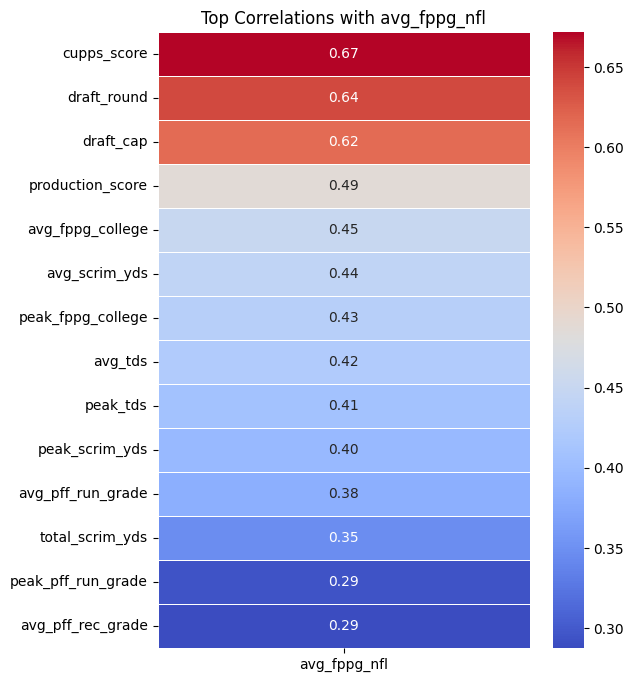

In [586]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Get correlations with avg_fppg_nfl and sort them (using abs since DC is inversely correlated)
correlations = correlation_matrix["avg_fppg_nfl"].dropna().abs().sort_values(ascending=False)

# Select the top N correlated features (excluding avg_fppg_nfl itself)
top_corr_features = correlations.index[1:15]  # Get top 10 correlated features

# Extract the correlation matrix for the selected features
top_corr_matrix = correlation_matrix.loc[top_corr_features, ["avg_fppg_nfl"]]

# Plot the heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Top Correlations with avg_fppg_nfl")
plt.show()



In [587]:
# Define features (X) and target variable (y)
X = df.drop(columns=['avg_fppg_nfl'])  # Drop target column from features
y = df['avg_fppg_nfl']  # Target variable

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (278, 40)
Test set size: (50, 40)


In [588]:
#Update these arguments based on the optimizer several cells below (if needed)
xgb_optimized = xgb.XGBRegressor(
    colsample_bytree=0.7,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=200,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Train the model
xgb_optimized.fit(X_train, y_train)

print("✅ XGBoost model training complete!")



✅ XGBoost model training complete!


In [589]:
# Make predictions on the test set
y_pred = xgb_optimized.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Evaluation:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

📊 Model Evaluation:
MAE: 2.999
RMSE: 4.160
R² Score: 0.227


In [590]:
#Dont run this cell every time...only if we want to debug/identify the best parameters for XGBoost
run_optimizer = False

if run_optimizer:
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

    xgb_grid = GridSearchCV(
        xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        param_grid=param_grid,
        cv=3,
        scoring='r2'
    )

    xgb_grid.fit(X_train, y_train)
    print("Best Parameters:", xgb_grid.best_params_)


/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_10187/1835262553.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='coolwarm')


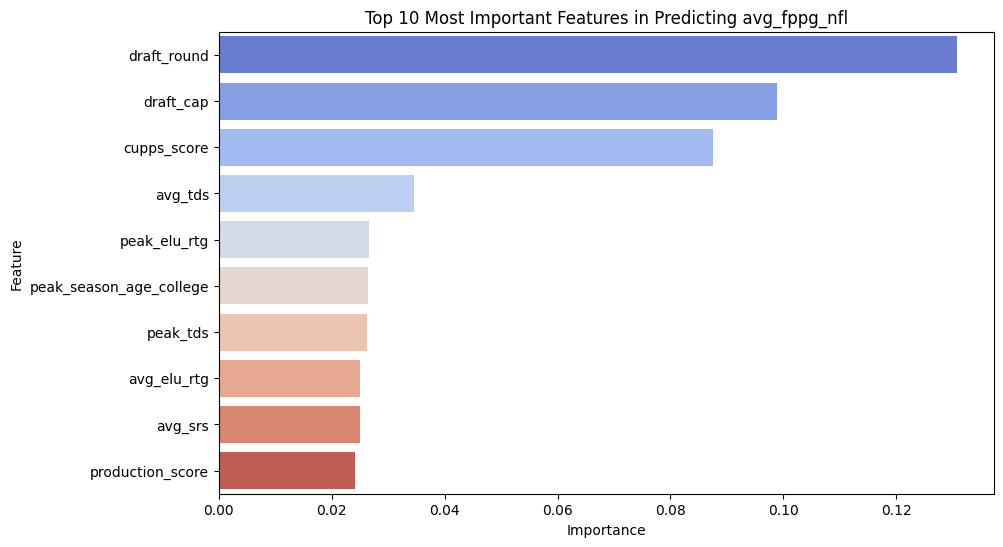

In [591]:
def plot_xgboost_feature_importance(model):
    importance = model.feature_importances_
    feature_names = X_train.columns

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='coolwarm')
    plt.title("Top 10 Most Important Features in Predicting avg_fppg_nfl")
    plt.show()

plot_xgboost_feature_importance(xgb_optimized)


Feature importance chart shows us that the correct features are being attributed to the highest correlation with FPPG in the NFL.

In [592]:
y_pred_xgb = xgb_optimized.predict(X_test)

# Create a DataFrame to compare actual vs. predicted
results_df = pd.DataFrame({
    "Actual FPPG": y_test.values,
    "Predicted FPPG": y_pred_xgb
})

# Show the first few rows
print(results_df)


    Actual FPPG  Predicted FPPG
0          9.00       10.769421
1         11.48        3.878346
2          4.72        2.300499
3          8.50        6.832910
4         14.60        5.237393
5          4.90        2.427832
6          1.97        9.598485
7          2.42        2.474285
8         14.28        7.891034
9         14.24        6.202450
10         9.88       10.437611
11        18.87        9.450499
12         2.80        4.936994
13         5.10        2.470155
14         4.79        2.331308
15         4.66        4.131859
16         1.28        2.482923
17         0.24        3.193953
18         0.20        2.335028
19         1.58        1.925302
20         2.63        2.013041
21         0.60        2.772131
22         4.86        8.240959
23         4.99        2.525802
24         0.10        2.080546
25        14.49        4.426778
26         4.43        2.923028
27         2.78        2.713981
28         5.04        2.483506
29         0.52        5.644693
30      

We can see from the above output that our model is still struggling mightily to predict high-end players effectively. For example, a player with 21.55 FPPG in the NFL is getting predicted 10.32 in the model. Let's figure out why this is and address it.

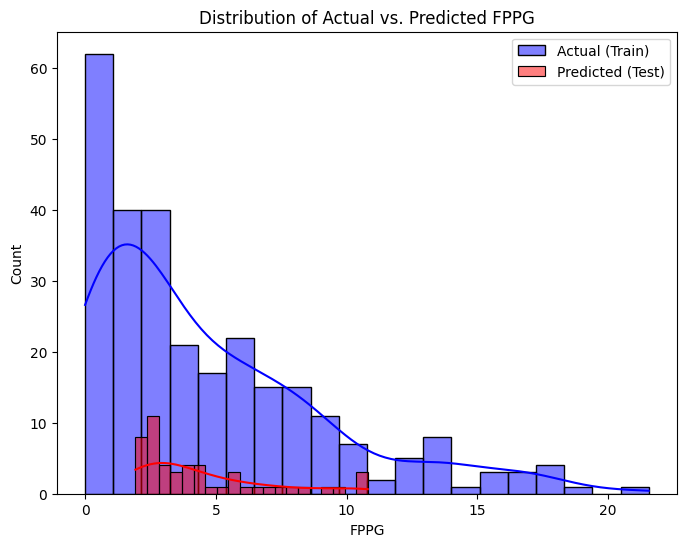

In [593]:
plt.figure(figsize=(8,6))

sns.histplot(y_train, bins=20, label="Actual (Train)", kde=True, color="blue")
sns.histplot(y_pred_xgb, bins=20, label="Predicted (Test)", kde=True, color="red")

plt.title("Distribution of Actual vs. Predicted FPPG")
plt.xlabel("FPPG")
plt.ylabel("Count")
plt.legend()
plt.show()


We can see that our data is quite left-skewed - many RBs with minimal FPPG make up a significant portion of our dataset. We need to update the model to more effectively handle variance, especially to the higher end.

In [667]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 🔹 Use raw FPPG (no log1p)
X = df.drop(columns=['avg_fppg_nfl', 'avg_fppg_college'])
y = df['avg_fppg_nfl']

# 🔹 Stratified Train/Test Split based on binned y
y_binned = pd.qcut(y, q=8, labels=False, duplicates="drop")
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
train_idx, test_idx = next(splitter.split(X, y_binned))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# 🔹 Sample weights to emphasize high-FPPG players
sample_weights = np.where(y_train > 15, 5,
                  np.where(y_train > 10, 2, 1))

# 🔹 General Model
xgb_general = xgb.XGBRegressor(
    max_depth=6, n_estimators=500, learning_rate=0.01,
    subsample=0.8, colsample_bytree=0.7,
    objective="reg:pseudohubererror", random_state=42
)
xgb_general.fit(X_train, y_train, sample_weight=sample_weights)

# 🔹 Quantile Model (0.99)
xgb_quantile = xgb.XGBRegressor(
    max_depth=8, n_estimators=500, learning_rate=0.01,
    subsample=0.8, colsample_bytree=0.7,
    objective="reg:quantileerror", quantile_alpha=0.99,
    random_state=42
)
xgb_quantile.fit(X_train, y_train, sample_weight=sample_weights)

# 🔹 Make predictions
y_pred_general = xgb_general.predict(X_test)
y_pred_quantile = xgb_quantile.predict(X_test)
y_test_actual = y_test

# 🔹 Adaptive Blending
gp = y_pred_general
dc = X_test["draft_cap"]
cupps = X_test["cupps_score"]
draft_weight = np.clip(dc, 0.1, 1.0)

blend_factor = np.clip((cupps / 100) * draft_weight, 0.1, 0.95)
y_pred_hybrid = y_pred_quantile * blend_factor + y_pred_general * (1 - blend_factor)

# 🔹 Evaluation
mae = mean_absolute_error(y_test_actual, y_pred_hybrid)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_hybrid))
r2 = r2_score(y_test_actual, y_pred_hybrid)

print(f"📊 Hybrid Model Evaluation:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")


📊 Hybrid Model Evaluation:
MAE: 2.798
RMSE: 3.354
R² Score: 0.435


📊 Expected vs. Actual FPPG:
 Actual FPPG  Predicted FPPG  Residuals (Actual - Predicted)
       21.55       17.386194                        4.163806
       16.16        8.977512                        7.182488
       13.88       15.019645                       -1.139645
       13.55       17.121295                       -3.571295
       12.44        9.026842                        3.413158
       12.17        9.281710                        2.888290
       11.48        7.461500                        4.018500
       11.48       11.502703                       -0.022703
        9.46        9.724289                       -0.264289
        9.35        4.282774                        5.067226
        8.50        7.762304                        0.737696
        8.46        7.180150                        1.279850
        8.45       10.093764                       -1.643764
        8.32        6.614709                        1.705291
        8.25       13.612441                       -5.362

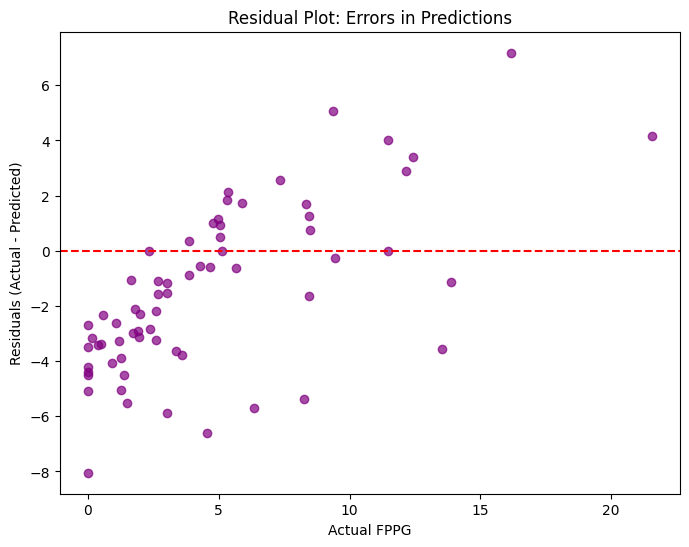

In [668]:
# 🔹 Compute Residuals
df_results = pd.DataFrame({
    "Actual FPPG": y_test_actual.values,
    "Predicted FPPG": y_pred_hybrid,
    "Residuals (Actual - Predicted)": y_test_actual.values - y_pred_hybrid
})

# 🔹 Print Expected vs. Actual FPPG
print("📊 Expected vs. Actual FPPG:")
print(df_results.sort_values(by="Actual FPPG", ascending=False).to_string(index=False)) 

residuals = y_test_actual - y_pred_hybrid  # Actual - Predicted
# 🔹 Plot Residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, residuals, color="purple", alpha=0.7)
plt.axhline(y=0, color='red', linestyle='dashed')  # Zero error reference line
plt.xlabel("Actual FPPG")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot: Errors in Predictions")
plt.show()



In [661]:
# Step 1: Find the index of that row in the test set
target_actual = 0.00
target_pred = 10.18  # or something close

# Tolerance for floating point match
tolerance = 0.1

# Find matching row
mask = (np.isclose(y_test_actual, target_actual, atol=1e-2)) & \
       (np.isclose(y_pred_hybrid, target_pred, atol=tolerance))

# Get the index in your DataFrame
matching_idx = y_test_actual[mask].index[0]

# Step 2: Look up the player info
print(df.loc[matching_idx])


draft_cap                                  0.012277
production_score                          47.187000
size_score                                47.575000
cupps_score                               32.224300
ras                                        4.010000
height                                    69.000000
weight                                   180.000000
avg_fppg_college                          22.980000
peak_fppg_college                         26.590000
avg_scrim_yds                           1861.500000
peak_scrim_yds                          2364.000000
total_scrim_yds                         7446.000000
avg_receptions                            25.000000
peak_receptions                           28.000000
avg_games_played                          13.500000
peak_games_played                         14.000000
avg_tds                                   16.750000
peak_tds                                  20.000000
avg_pff_run_grade                         74.030000
peak_pff_run

In [639]:
elite_idx = y_test_actual.idxmax()  # Index of the top performer
print(X_test.loc[elite_idx])


draft_cap                                  0.765928
production_score                          97.769000
size_score                                88.900000
cupps_score                               97.313400
ras                                        8.520000
height                                    71.000000
weight                                   202.000000
peak_fppg_college                         29.480000
avg_scrim_yds                           1709.330000
peak_scrim_yds                          2664.000000
total_scrim_yds                         5128.000000
avg_receptions                            33.000000
peak_receptions                           45.000000
avg_games_played                          12.670000
peak_games_played                         14.000000
avg_tds                                   10.330000
peak_tds                                  16.000000
avg_pff_run_grade                         79.530000
peak_pff_run_grade                        85.600000
avg_pff_rec_

/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_10187/1835262553.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='coolwarm')


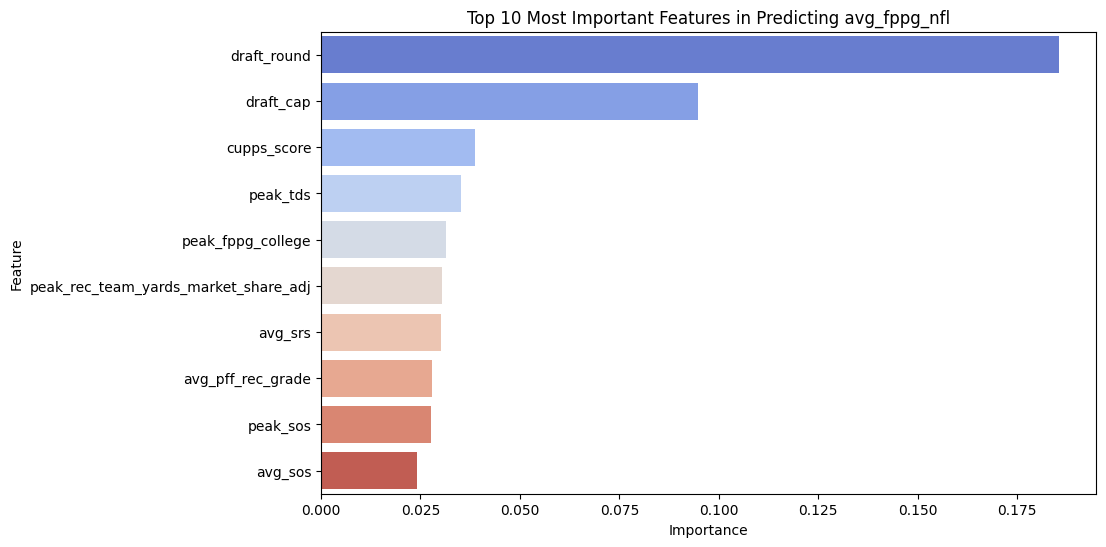

/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_10187/1835262553.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='coolwarm')


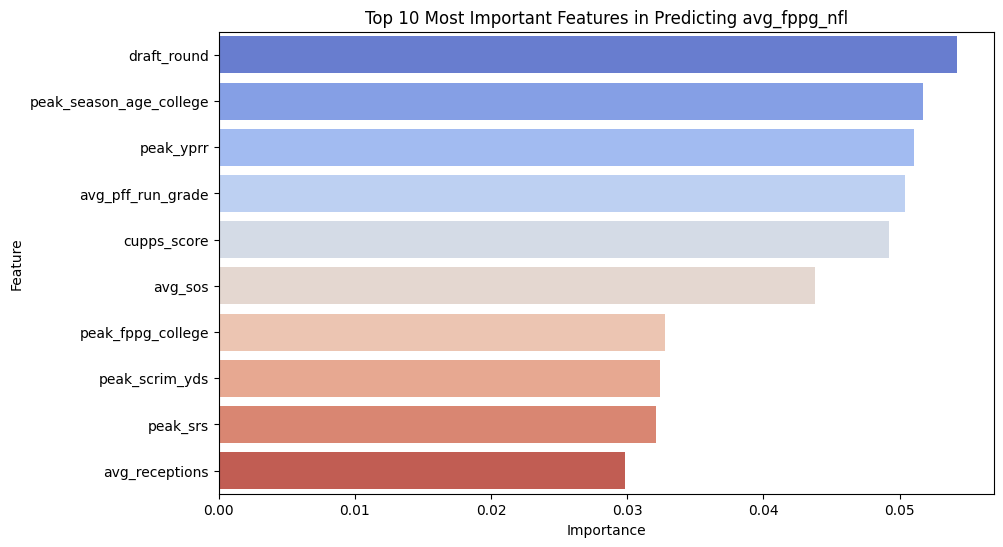

In [602]:
plot_xgboost_feature_importance(xgb_general)
plot_xgboost_feature_importance(xgb_quantile)

In [597]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping


# Standardize the features (important for NN stability)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [598]:
# Define NN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # First hidden layer
    Dropout(0.2),  # Dropout to reduce overfitting
    Dense(64, activation='relu'),  # Second hidden layer
    Dropout(0.2),
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1)  # Output layer (regression, so no activation)
])

# Compile model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],  # Stops training when val_loss stops improving
    verbose=1
)



/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,489 (60.50 KB)

 Trainable params: 15,489 (60.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2.0823 - mae: 1.1582 - val_loss: 2.0432 - val_mae: 1.2654
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3970 - mae: 0.9943 - val_loss: 0.6045 - val_mae: 0.6456
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8655 - mae: 0.7453 - val_loss: 0.7680 - val_mae: 0.7270
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6936 - mae: 0.7014 - val_loss: 0.4969 - val_mae: 0.5535
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6226 - mae: 0.6498 - val_loss: 0.4577 - val_mae: 0.5160
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5313 - mae: 0.6017 - val_loss: 0.6321 - val_mae: 0.6394
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5512 - mae: 0.6118 - val_loss: 0.4664 - val_mae: 0.5424
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5066 - mae: 0.5812 - val_loss: 0.4807 - val_mae: 0.5508
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4161 - ma

In [599]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)

print("📊 Neural Network Model Evaluation:")
print(f"MAE (Mean Absolute Error): {test_mae:.3f}")
print(f"Loss (MSE): {test_loss:.3f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5818 - mae: 0.6277
📊 Neural Network Model Evaluation:
MAE (Mean Absolute Error): 0.616
Loss (MSE): 0.568


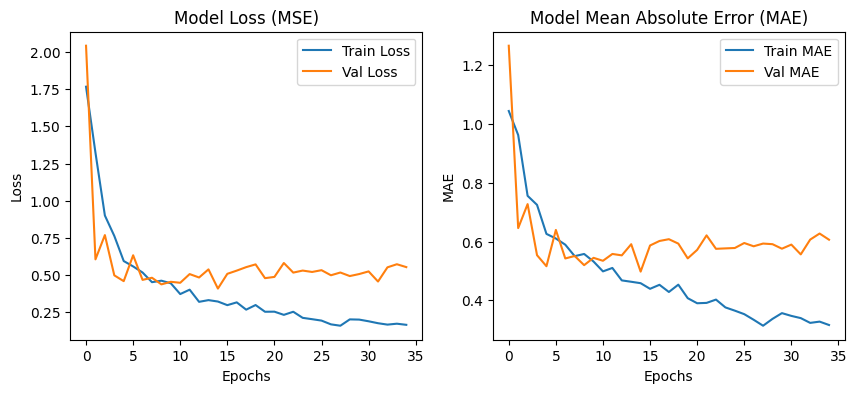

In [600]:
# Plot Loss (MSE)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [601]:
# Make predictions
y_pred_nn = model.predict(X_test_scaled).flatten()

# Evaluate performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("📊 Neural Network Model Final Results:")
print(f"MAE: {mae_nn:.3f}")
print(f"RMSE: {np.sqrt(mse_nn):.3f}")
print(f"R² Score: {r2_nn:.3f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
📊 Neural Network Model Final Results:
MAE: 0.616
RMSE: 0.754
R² Score: 0.157
